In [5]:
from typing import TypedDict, Sequence, Annotated
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage, HumanMessage, AIMessage, FunctionMessage
from langchain.agents import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma 
import os

In [6]:
load_dotenv()

llm = ChatOpenAI(model="gpt-4o", temperature=0)

### Generate the document retriever
- generate the vector database and if it already exist load it and use it to generate the retriever 
- First get the file to embed, the embeddings , split the file, and create a vector database with it. With the as_retriever method create the retriever

In [7]:
# get document retriever function 
def get_retriever(file_path):
    #get embedding
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

    #get file and folder path
    # script_dir = os.path.dirname(__file__)
    cur_dir = os.getcwd()
    script_dir = os.path.dirname(cur_dir)
    pdf_path = os.path.join(script_dir, file_path)  #file path
    persist_directory = script_dir  #folder path

    collection_name = "resume_checker" #collection name
    chroma_db_path = os.path.join(persist_directory, "chroma.sqlite3") #path to chroma.db

    if not os.path.exists(pdf_path): # if pdf file doesnt exist
        raise FileNotFoundError(f'PDF file not found in {pdf_path}')

    #if chroma.db already exist, just load it
    #if it does exist create a new one
    if os.path.exists(chroma_db_path):
        print("Loading existing Chroma DB...")
        vectorstore = Chroma(
            persist_directory=persist_directory,
            embedding_function=embeddings,
            collection_name=collection_name
        )
    else:
        print("Creating new Chroma DB...")

        #load the pdf
        pdf_loader = PyPDFLoader(pdf_path)
        try:
            pages = pdf_loader.load()
            print(f"Document contains {len(pages)} pages")
        except Exception as e:
            print("Error Loading PDF", e)
            raise

        #split the pdf
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200
        )
        pages_split = text_splitter.split_documents(pages) # pass the loaded pages to the splitte config to created splitted docs

        #create the chroma.db (vector database)
        try:
            vectorstore = Chroma.from_documents(
                documents=pages_split,
                embedding=embeddings,
                persist_directory=persist_directory, #optional parameter if not provided, data will be in-memory only
                collection_name=collection_name  # optional  - use to give name to embeddings in the vector database.
            )
            # vectorestore could also only have document and bedding parameter
            # vectorstore = Chroma.from_documents(documents=pages_split, embedding=embeddings) 

            print("Chroma DB created and persisted.")
        except Exception as e:
            print(f"Error Setting Chroma DB: {str(e)}")
            raise

    #user the database to gerate a retriever
    retriever = vectorstore.as_retriever(
        search_type="similarity",
        search_kwargs={"k": 5}
    )
    return retriever# get document retriever function 
 

In [8]:
# create a retriever
retriever = get_retriever("resume.pdf")

Loading existing Chroma DB...


### Create a tool that takes a quert and retrieve similar record from the embeded vector database
- bind the tool to llm with .bind_tools method

In [ ]:
@tool
def retrieval_tool(query:str)->str:
    """
    This tool searches record from a resume and returns the result
    """
    print('retrieving answer')
    docs = retriever.invoke(query)

    if not docs:
      return "I found no releveant information in the Document"  
    
    results =[]

    for i, doc in enumerate(docs,1):
        results.append(f"Document {i}:\n {doc.page_content}")
    
    return "\n\n".join(results)

tools = [retrieval_tool]

llm = llm.bind_tools(tools)

### Declare the nodes
- Node call_llm will invoke the llm

In [10]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]




system_prompt="""
You are intelligent AI assistant who answers questions about resume uploaded in your konwledge base
Use the retriever tool available to answer questions about the resume. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""


def call_llm(state: AgentState) -> AgentState:
    """ Function to call the LLM with the current state."""
    messages = [SystemMessage(content=system_prompt)] + list(state['messages'])
    message = llm.invoke(messages)
    return {"messages": [message]}  # LangGraph appends this to state['messages']


def should_continue(state:AgentState):
    """ Check if the last message contains tool calls"""
    result = state['messages'][-1]

    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0



tools_dict = {our_tool.name: our_tool for our_tool in tools} # creating a dictionary from our list of tools


#LLM Agent

 





def take_action(state: AgentState) -> AgentState:
    tool_calls = state['messages'][-1].tool_calls
    results = []
    
    for t in tool_calls:
        tool_name = t['name']
        query = t['args'].get('query', '')
        if tool_name not in tools_dict:
            content = "Error: tool not found"
        else:
            content = tools_dict[tool_name].invoke(query)
        tm = ToolMessage(tool_call_id=t['id'], name=tool_name, content=str(content))
        results.append(tm)

    # Return full message list: this lets LangGraph append correctly
    return {"messages": results}

retrieving answer


In [36]:
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("retriever_agent",take_action)

graph.set_entry_point("llm")
graph.add_conditional_edges(
    "llm",
    should_continue,
    {True:"retriever_agent", False: END}
)

graph.add_edge("retriever_agent","llm")

rag_agent = graph.compile()

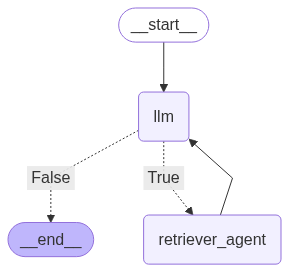

In [37]:
rag_agent

In [38]:
def running_agent():
    print("\n*** RAG AGENT***")

    while True:
        user_input = input("\n What is your question: ")
        if user_input.lower() in ['exit','quit']:
            break

        messages = [HumanMessage(content=user_input)] # converts back to Human type

        result = rag_agent.invoke({"messages": messages})

        print("\n=== ANSWER ===")
        print(result['messages'][-1].content)

In [39]:
running_agent()


*** RAG AGENT***



 What is your question:  who is the prodigal son



=== ANSWER ===
The term "prodigal son" originates from a parable in the Bible, specifically in the Gospel of Luke 15:11-32. The parable tells the story of a younger son who asks his father for his share of the inheritance and then leaves home to squander his wealth in reckless living. After losing everything, he returns home, repentant and willing to work as a servant. However, his father welcomes him back with open arms and celebrates his return, symbolizing forgiveness and redemption. The story is often interpreted as an illustration of God's forgiveness and love for those who repent.



 What is your question:  what happened to the second son after the first one returned



=== ANSWER ===
Could you please provide more context or specify which resume or individual you are referring to? This will help me assist you better.



 What is your question:  list the strong points in the resume


retrieving answer

=== ANSWER ===
Emmanuel Bakare's resume highlights several strong points:

1. **Certifications**:
   - Sun Certified Programmer for the Java 2 Platform (SCJP).
   - Oracle Certified Professional (OCP).
   - Sun Certified Solaris Administrator (SCSA).
   - Microsoft Certified Technology Specialist (MCTS) for Microsoft Office SharePoint Server 2007.
   - IT Infrastructure Library (ITIL V.3) for IT Service Management.
   - Certified Alvarion System Specialist in Wireless Technology.
   - Certificate of Proficiency in Advanced Telecommunication (CPAT).

2. **Technical Skills**:
   - Proficient in developing database systems with Microsoft .NET C#.
   - Experience in designing banners and graphics for user interfaces and advertisements.
   - Configuring, planning, building, and maintaining Windows SharePoint portals.
   - Proficient use of video editing and imaging tools such as Photoshop, Premiere Pro, After Effects, Audition, Encore, and Illustrator.

3. **Project Manag


 What is your question:  pick one strongest point of Emmanuel Bakare


retrieving answer

=== ANSWER ===
One of the strongest points of Emmanuel Bakare is his extensive professional experience and certifications in the field of Information Technology. He is a Sun Certified Programmer for the Java 2 platform (SCJP), an Oracle Certified Professional (OCP), and a Sun Certified Solaris Administrator (SCSA). Additionally, he holds a Microsoft Certified Technology Specialist (MCTS) certification for Microsoft Office SharePoint Server 2007, and is certified in IT Infrastructure Library (ITIL V.3) for IT Service Management. These certifications highlight his expertise and commitment to professional development in IT ([Document 2](#)).



 What is your question:  what position in the IT field should he be looking for


retrieving answer

=== ANSWER ===
Based on Emmanuel Bakare's skills and experience in the IT field, he should consider looking for positions such as:

1. **IT Project Manager**: His experience in coordinating teams, implementing IT projects, and managing project timelines and budgets makes him well-suited for this role. His skills in risk management and project delivery within budget and quality criteria are also relevant.

2. **IT Service Manager**: With his knowledge of IT Infrastructure Library (ITIL) systems and best practices in service design, strategy, transition, operation, and continual service improvement, he could excel in managing IT services to enhance customer experiences.

3. **Network Administrator/Manager**: His experience in technical hardware support supervision, networking planning, support, and network cabling and configuration supervision aligns well with roles focused on network management.

4. **ERP System Manager**: His experience in developing and managing Ent


 What is your question:  what do you think his salary range should be


retrieving answer

=== ANSWER ===
Emmanuel Bakare has a diverse and extensive background in IT and management, with significant experience and certifications that could influence his salary range. Here are some key points from his resume:

1. **Certifications**: 
   - Sun Certified Programmer for the Java 2 Platform (SCJP)
   - Oracle Certified Professional (OCP)
   - Sun Certified Solaris Administrator (SCSA)
   - MCTS – Microsoft Office SharePoint Server 2007
   - IT Infrastructure Library – ITIL V.3

2. **Professional Experience**:
   - Managing Director at Interface Connect Limited since July 2020
   - Creative Director/CEO at JIKSYS Solutions Limited since March 2013
   - Senior Analyst Database/Web at Nigeria Liquefied Natural Gas (NLNG) /PPC since October 2009

3. **Skills**:
   - Application development with Python and Django
   - Database management with MySQL, Microsoft SQL Server, Oracle, PostgreSQL
   - Front-end development with HTML, CSS, JavaScript, and various framework


 What is your question:  what if he is working in Nigeria


retrieving answer

=== ANSWER ===
The resume does not explicitly mention the current location of the individual. However, there are multiple references to work and projects in Nigeria, such as:

- Development and maintenance of intranet site for Nigeria LNG and Nigeria LNG Residential Area.
- Development of National Assembly Service Commission Website.
- Development of a web-based CRM Application for Suburban Broadband.
- Development of a web-based Microfinance Banking Solution for Ugah Community Bank in Ugah, Anambra State.
- Conducting Infrastructure Management Audit and other IT-related tasks for Suburban System Limited in Abuja.

These references suggest that the individual has significant work experience in Nigeria. If he is currently working in Nigeria, it would align with his past professional engagements.



 What is your question:  what would be his salary range in Nigeria


retrieving answer

=== ANSWER ===
Emmanuel Bakare is currently serving as the Managing Director at Interface Connect Limited and as the Creative Director/CEO at JIKSYS Solutions Limited. His roles involve designing training solutions, managing staff operations, consulting, marketing strategy implementation, and developing enterprise resource planning systems, among other responsibilities.

Given his extensive experience and leadership roles, his salary range in Nigeria would likely be on the higher end for similar positions. However, the exact salary can vary significantly based on the industry, company size, and location within Nigeria. Generally, for high-level executive positions like Managing Director or CEO in Nigeria, the salary can range from several million to tens of millions of Naira annually, depending on the factors mentioned.



 What is your question:  exit


---
## code below  is only for testing - not part of original code
- the code is to manually test each stage of the application

In [2]:
user_input= "List  resume database experience"

human_msg=AgentState(messages=[HumanMessage(content=user_input)])

NameError: name 'AgentState' is not defined

In [184]:
tool_msg1=call_llm(human_msg)

In [185]:
tool_msg2 = take_action(tool_msg1)

retrieving answer


In [1]:
human_msg

NameError: name 'human_msg' is not defined

In [194]:
# add uid
import uuid

def add_id(msg):
    plain_msg = msg["messages"][-1]
    
    msg_id = str(uuid.uuid4())

    # Create a new HumanMessage with the same content and a custom id added via additional_kwargs
    return  HumanMessage(
        content=msg1.content,
        response_metadata=msg1.response_metadata,
        additional_kwargs={**msg1.additional_kwargs},
        id=  msg_id
    )


# change it to accomodate other message type

In [195]:
msg1  = add_id(human_msg) 
tool1 = add_id(tool_msg1)
tool2 = add_id(tool_msg2)
all_msgs = all_msg= {
"messages":[mgs1, tool1, tool2]
}

In [191]:
type(tool_msg1["messages"][-1])

langchain_core.messages.ai.AIMessage

In [149]:
human_msg

{'messages': [HumanMessage(content='List  resume database experience', additional_kwargs={}, response_metadata={})]}

In [142]:
k = {"boy": 2}
l = {"girls": 12}
x = {"class": 12}

y = {**k, **l, **x}
print(y)

{'boy': 2, 'girls': 12, 'class': 12}
